# Support Vector Machines (Linear & Kernel)

Compare LinearSVC (with calibration) and RBF-kernel SVC. Scaling is critical; Also handle probability calibration where needed.

zsh:1: command not found: wget
AUC-ROC: 0.593  |  AP (PR AUC): 0.379
Confusion matrix @ threshold 0.5 :
 [[3326  140]
 [1402  132]]

Report:
               precision    recall  f1-score   support

           0      0.703     0.960     0.812      3466
           1      0.485     0.086     0.146      1534

    accuracy                          0.692      5000
   macro avg      0.594     0.523     0.479      5000
weighted avg      0.637     0.692     0.608      5000



/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunm

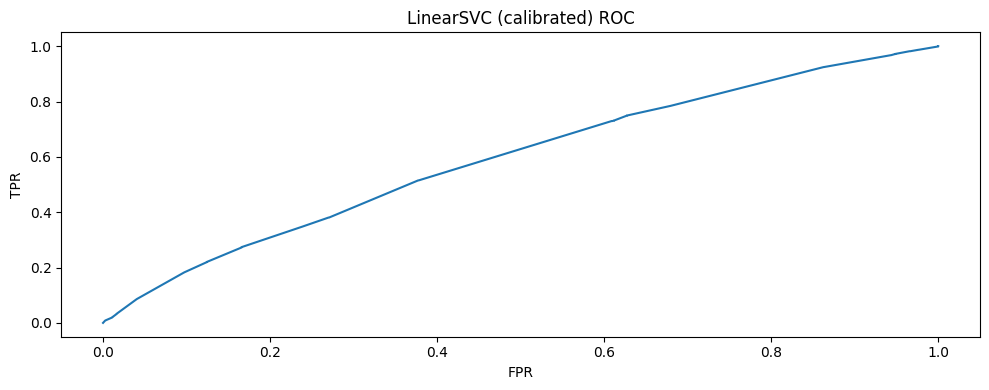

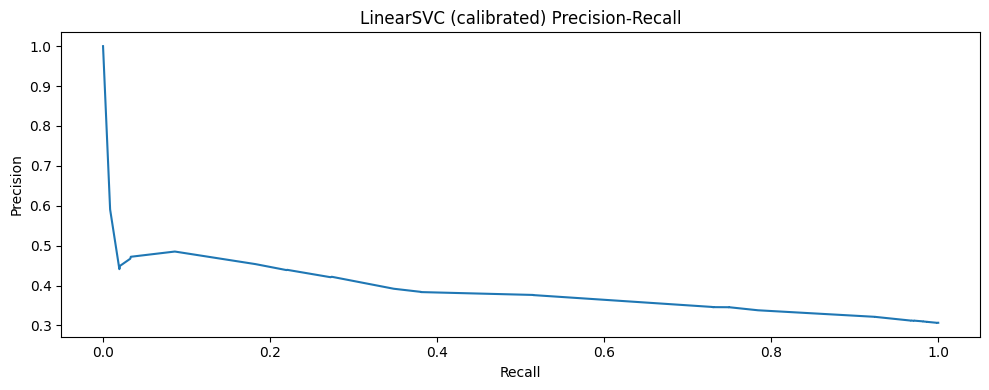

AUC-ROC: 0.544  |  AP (PR AUC): 0.354
Confusion matrix @ threshold 0.5 :
 [[3452   14]
 [1521   13]]

Report:
               precision    recall  f1-score   support

           0      0.694     0.996     0.818      3466
           1      0.481     0.008     0.017      1534

    accuracy                          0.693      5000
   macro avg      0.588     0.502     0.417      5000
weighted avg      0.629     0.693     0.572      5000



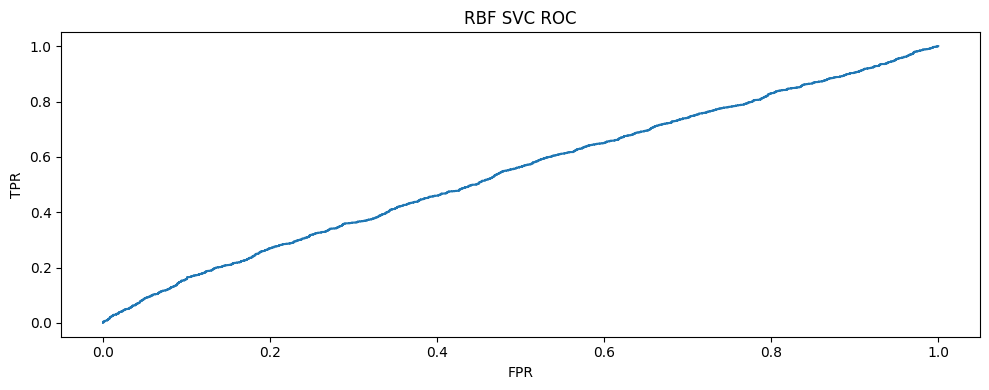

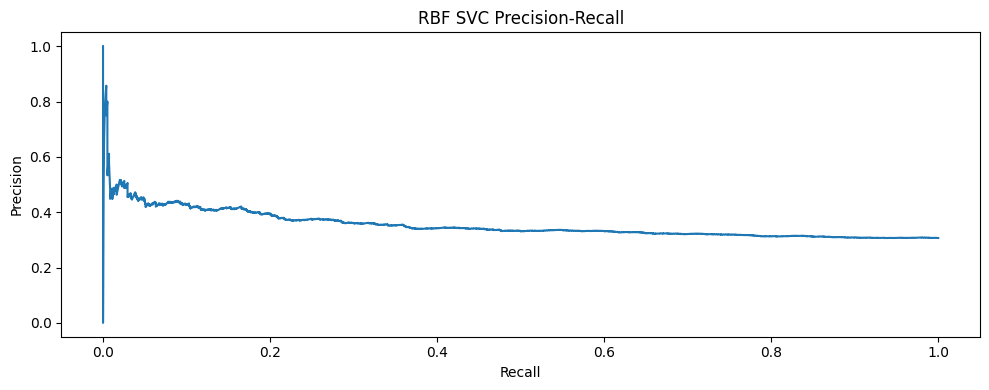

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV

!wget -q https://raw.githubusercontent.com/Jihun-ust/ust-mail-557/main/Classification/classification_utils.py
import classification_utils as utils
csv_path = "https://raw.githubusercontent.com/Jihun-ust/ust-mail-557/main/Classification/classification.csv"

df = pd.read_csv(csv_path, parse_dates=["ts"]).sort_values("ts")
train, test = utils.chrono_split(df, "ts", test_frac=0.2)

features = ["ad_channel","device","region","campaign","spend_l7","pages_per_session","sessions_l30","time_on_site_s","pricing_views_l7","email_opens_l30","past_purchases","tenure_days","discount_flag","competitor_visits"]
target = "converted"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

pre = ColumnTransformer([
    ("num", StandardScaler(), ["spend_l7","pages_per_session","sessions_l30","time_on_site_s","pricing_views_l7","email_opens_l30","past_purchases","tenure_days"]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["ad_channel","device","region","campaign"]),
    ("bin", "passthrough", ["discount_flag","competitor_visits"])
])

# LinearSVC + calibration (no native predict_proba)
lin = Pipeline([("pre", pre), ("svc", LinearSVC(C=1.0, class_weight=None, random_state=42))])
lin.fit(X_train, y_train)
# Calibrate on a slice of the training set
val = train.iloc[-5000:]
cal_lin = CalibratedClassifierCV(lin, cv="prefit", method="isotonic")
cal_lin.fit(val[features], val[target])
probs_lin = cal_lin.predict_proba(X_test)[:,1]
_ = utils.evaluate_classifier(y_test, probs_lin, title_prefix="LinearSVC (calibrated)")

# RBF SVC (native probas if probability=True; more expensive)
rbf = Pipeline([("pre", pre), ("svc", SVC(C=1.0, kernel="rbf", gamma="scale", probability=True, random_state=42))])
rbf.fit(X_train, y_train)
probs_rbf = rbf.predict_proba(X_test)[:,1]
_ = utils.evaluate_classifier(y_test, probs_rbf, title_prefix="RBF SVC")

### High-level Report Review (Example)
1. Linear SVM (Report 1)
   - A linear kernel draws one straight hyperplane to separate classes.
   - In imbalanced data (3,466 zeros vs 1,534 ones), it still tries to carve out some space for positives (class 1).
   - That’s why you see recall ≈ 8.6% for class 1: the plane catches a slice of positives, though most still get missed.
   - Precision for class 1 (≈48%) means about half of what it flags is truly positive, not good, but not collapsing.
 
2. RBF SVM (Report 2)
   - The RBF kernel maps data into a higher-dimensional space and fits curved, localized boundaries.
   - With this imbalance and likely overlapping features, the RBF model has “decided” the safest way to maximize margin and accuracy is to treat almost everything as class 0.
   - Hence: class 0 recall ≈ 99.6% (almost perfect), but class 1 recall collapses to 0.8%.
   - The kernel flexibility + imbalance essentially led to mode collapse into majority-class prediction.
 
3. Why this happens
   - Linear kernel is more “rigid”: it must at least cut across the feature space with a line, which often forces it to pick up some positives.
   - RBF kernel is more flexible: if positives are sparse/noisy and not well-separated, it can just “hug” the majority cloud and ignore the minority, because that minimizes hinge loss and maximizes margin.
 
4. Practical takeaway
   - In imbalanced datasets, RBF SVMs can easily overfit to the majority unless you:
   - Use class_weight="balanced" (forces the margin to penalize missing positives more).
   - Adjust the decision threshold on probabilities.
   - Try re-sampling (SMOTE/undersample).
   - Otherwise, a linear SVM can sometimes be less biased because it’s constrained to a single hyperplane.
 
In short:
   - Linear SVM (Report 1): At least picks up some positives → better minority recall.
   - RBF SVM (Report 2): Collapses to majority-only → higher accuracy on paper, but almost useless for detecting positives.

#### (Advanced) Time-aware hyperparameter curves (C for Linear; C & γ for RBF)
   - Uses TimeSeriesSplit to respect chronology. For group-aware validation (e.g., by campaign), swap in GroupKFold or PurgedGroupTimeSeriesSplit and pass groups=train["campaign"].
   - **Warning**: Running this cell on Google Colab (free tire) can take over an hour. You're welcome to try it, but to save time the faster versions are provided below.

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunm

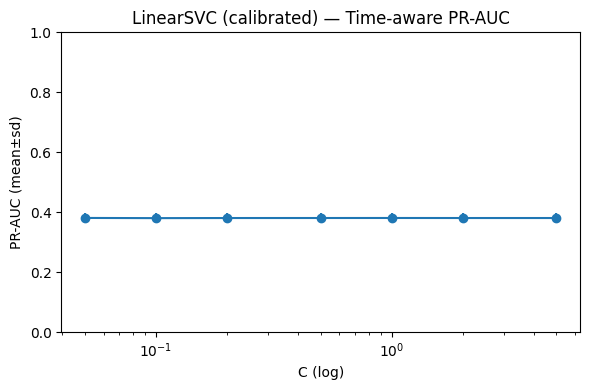

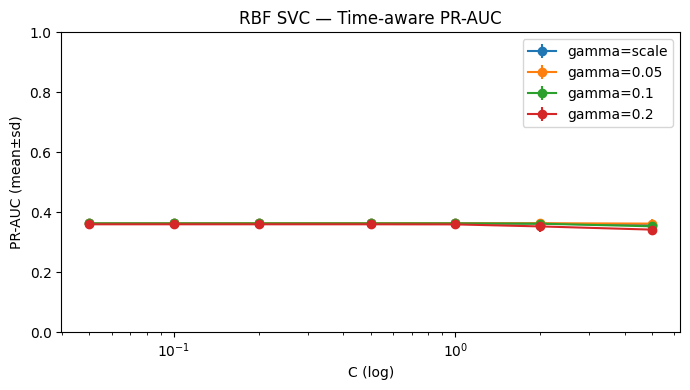

In [ ]:
# Time-aware hyperparameter curves
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score

def time_aware_scores(pipe, X, y, Cs, gammas=None, kernel="linear", metric="average_precision", n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for C in Cs:
        if kernel == "linear":
            base = Pipeline([("pre", pre), ("svc", LinearSVC(C=C, random_state=42))])
            row = {"C": C, "gamma": np.nan}
            row_scores = []
            for tr_idx, va_idx in tscv.split(X, y):
                base.fit(X.iloc[tr_idx], y.iloc[tr_idx])
                # calibrate on the tail of training fold to avoid leakage
                cal_slice = tr_idx[int(0.8*len(tr_idx)):]  # last 20% of train as calib
                cal = CalibratedClassifierCV(base, cv="prefit", method="isotonic")
                cal.fit(X.iloc[cal_slice], y.iloc[cal_slice])
                p = cal.predict_proba(X.iloc[va_idx])[:,1]
                s = average_precision_score(y.iloc[va_idx], p) if metric=="average_precision" else roc_auc_score(y.iloc[va_idx], p)
                row_scores.append(s)
            row["mean"], row["std"] = float(np.mean(row_scores)), float(np.std(row_scores))
            scores.append(row)

        elif kernel == "rbf":
            assert gammas is not None
            for g in gammas:
                base = Pipeline([("pre", pre), ("svc", SVC(C=C, gamma=g, kernel="rbf", probability=True, random_state=42))])
                row = {"C": C, "gamma": g}
                row_scores = []
                for tr_idx, va_idx in tscv.split(X, y):
                    base.fit(X.iloc[tr_idx], y.iloc[tr_idx])
                    p = base.predict_proba(X.iloc[va_idx])[:,1]
                    s = average_precision_score(y.iloc[va_idx], p) if metric=="average_precision" else roc_auc_score(y.iloc[va_idx], p)
                    row_scores.append(s)
                row["mean"], row["std"] = float(np.mean(row_scores)), float(np.std(row_scores))
                scores.append(row)

    import pandas as pd
    out = pd.DataFrame(scores)
    return out

Cs = [0.05, 0.1, 0.2, 0.5, 1, 2, 5]
Gammas = ["scale", 0.05, 0.1, 0.2]  # modest grid; expand if compute budget allows

lin_grid = time_aware_scores(lin, X_train, y_train, Cs=Cs, kernel="linear", metric="average_precision")
rbf_grid = time_aware_scores(rbf, X_train, y_train, Cs=Cs, gammas=Gammas, kernel="rbf", metric="average_precision")

# Plots
plt.figure(figsize=(6,4))
plt.errorbar(lin_grid["C"], lin_grid["mean"], yerr=lin_grid["std"], marker="o")
plt.xscale("log"); plt.ylim(0,1)
plt.xlabel("C (log)"); plt.ylabel("PR-AUC (mean±sd)"); plt.title("LinearSVC (calibrated), Time-aware PR-AUC")
plt.tight_layout(); plt.show()

# For RBF, one curve per gamma
plt.figure(figsize=(7,4))
for g in rbf_grid["gamma"].dropna().unique():
    sub = rbf_grid[rbf_grid["gamma"]==g].sort_values("C")
    lbl = f"gamma={g}"
    plt.errorbar(sub["C"], sub["mean"], yerr=sub["std"], marker="o", label=lbl)
plt.xscale("log"); plt.ylim(0,1); plt.legend()
plt.xlabel("C (log)"); plt.ylabel("PR-AUC (mean±sd)"); plt.title("RBF SVC, Time-aware PR-AUC")
plt.tight_layout(); plt.show()

Fast version: LinearSVC time-aware PR-AUC vs C

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[LinearSVC] Subsample n=6000, folds=3, grid=[0.05, 0.1, 0.2, 0.5, 1, 2, 5] → done in 0.2s


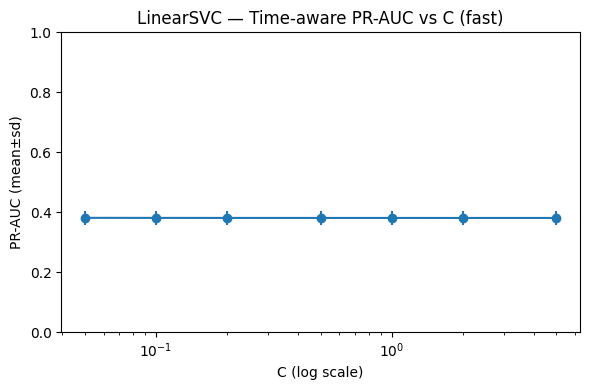

Best C (fast search): 0.05
AUC-ROC: 0.593  |  AP (PR AUC): 0.379
Confusion matrix @ threshold 0.5 :
 [[3328  138]
 [1403  131]]

Report:
               precision    recall  f1-score   support

           0      0.703     0.960     0.812      3466
           1      0.487     0.085     0.145      1534

    accuracy                          0.692      5000
   macro avg      0.595     0.523     0.479      5000
weighted avg      0.637     0.692     0.607      5000



/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunm

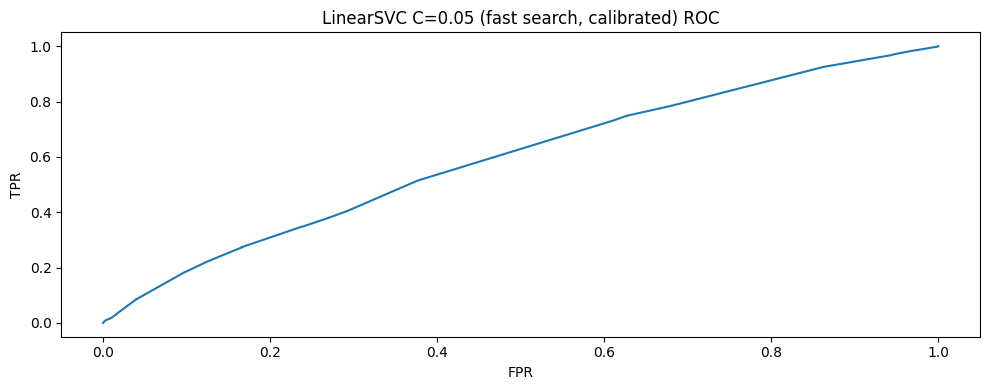

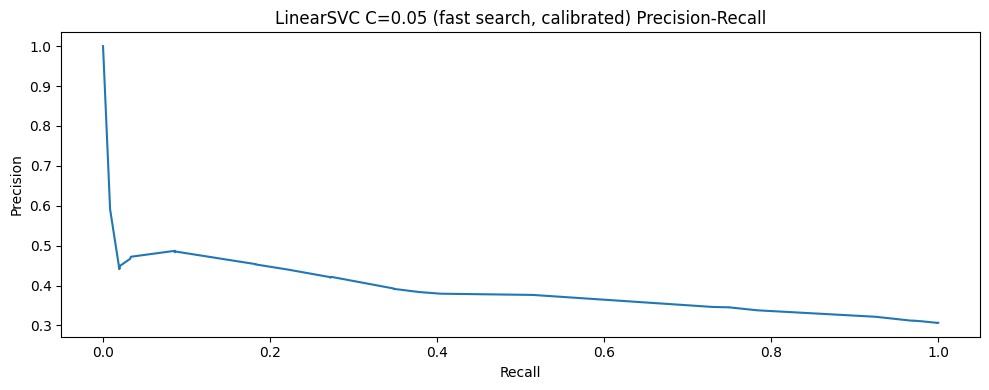

In [ ]:
# Fast version: LinearSVC time-aware PR-AUC vs C (subsample + 3 folds + decision_function)
import time, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score

t0 = time.time()

# Chronology-preserving subsample (use earliest portion of the training horizon)
frac = 0.30  # 30% of train; bump up if you have time
n_sub = max(2000, int(len(X_train) * frac))
X_sub, y_sub = X_train.iloc[:n_sub], y_train.iloc[:n_sub]

Cs = [0.05, 0.1, 0.2, 0.5, 1, 2, 5]
tscv = TimeSeriesSplit(n_splits=3)

scores_mean, scores_std = [], []

for C in Cs:
    fold_scores = []
    for tr_idx, va_idx in tscv.split(X_sub, y_sub):
        pipe = Pipeline([("pre", pre), ("svc", LinearSVC(C=C, random_state=42))])
        pipe.fit(X_sub.iloc[tr_idx], y_sub.iloc[tr_idx])
        # Use decision_function for ranking; AP accepts real-valued scores
        s = pipe.decision_function(X_sub.iloc[va_idx])
        ap = average_precision_score(y_sub.iloc[va_idx], s)
        fold_scores.append(ap)
    scores_mean.append(np.mean(fold_scores))
    scores_std.append(np.std(fold_scores))

elapsed = time.time() - t0
print(f"[LinearSVC] Subsample n={n_sub}, folds=3, grid={Cs} → done in {elapsed:.1f}s")

# Plot
plt.figure(figsize=(6,4))
plt.errorbar(Cs, scores_mean, yerr=scores_std, marker="o")
plt.xscale("log"); plt.ylim(0,1)
plt.xlabel("C (log scale)"); plt.ylabel("PR-AUC (mean±sd)")
plt.title("LinearSVC, Time-aware PR-AUC vs C (fast)")
plt.tight_layout(); plt.show()

# Optional: pick best C and (re)fit with calibration only once on full train
best_C = Cs[int(np.argmax(scores_mean))]
print("Best C (fast search):", best_C)
lin_fast = Pipeline([("pre", pre), ("svc", LinearSVC(C=best_C, random_state=42))]).fit(X_train, y_train)
cal_lin_fast = CalibratedClassifierCV(lin_fast, cv="prefit", method="isotonic")
cal_lin_fast.fit(train.iloc[-5000:][features], train.iloc[-5000:][target])
probs_lin_fast = cal_lin_fast.predict_proba(X_test)[:,1]
_ = utils.evaluate_classifier(y_test, probs_lin_fast, title_prefix=f"LinearSVC C={best_C} (fast search, calibrated)")

Fast version: RBF SVC time-aware PR-AUC heatmap

[RBF SVC] Subsample n=6000, folds=3, grid=2x2 → done in 2.5s


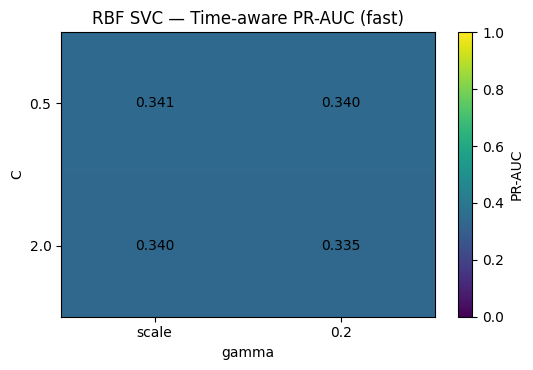

Best (C, gamma) from fast search: 0.5 scale
AUC-ROC: 0.544  |  AP (PR AUC): 0.354
Confusion matrix @ threshold 0.5 :
 [[3456   10]
 [1522   12]]

Report:
               precision    recall  f1-score   support

           0      0.694     0.997     0.819      3466
           1      0.545     0.008     0.015      1534

    accuracy                          0.694      5000
   macro avg      0.620     0.502     0.417      5000
weighted avg      0.649     0.694     0.572      5000



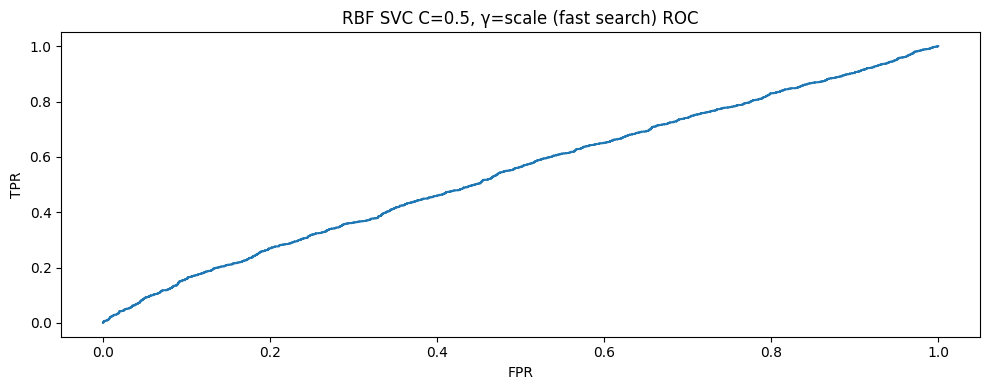

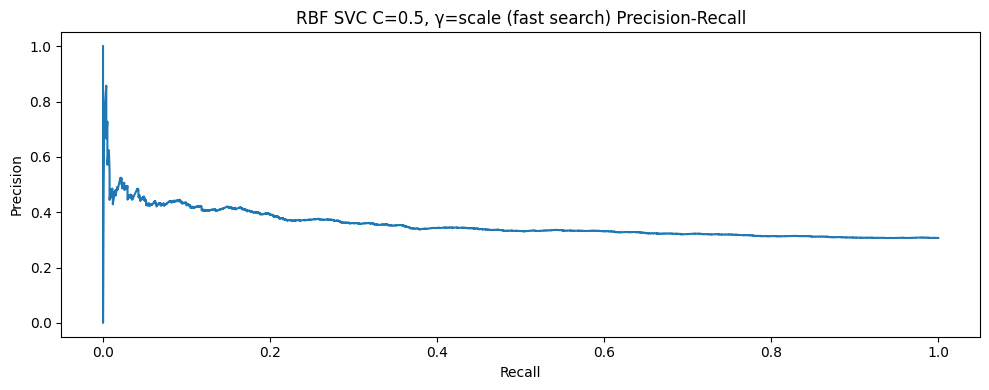

In [ ]:
# Fast version: RBF SVC time-aware PR-AUC heatmap (subsample + 3 folds + decision_function)
import time, numpy as np, matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

t0 = time.time()

# Reuse the same chronology-preserving subsample
X_sub, y_sub = X_train.iloc[:n_sub], y_train.iloc[:n_sub]

Cs = [0.5, 2.0]            # very small grid
Gammas = ["scale", 0.2]    # keep tiny; swap/add values if you have budget
tscv = TimeSeriesSplit(n_splits=3)

heat = np.zeros((len(Cs), len(Gammas)))
for i, C in enumerate(Cs):
    for j, g in enumerate(Gammas):
        fold_scores = []
        for tr_idx, va_idx in tscv.split(X_sub, y_sub):
            pipe = Pipeline([("pre", pre), ("svc", SVC(C=C, kernel="rbf", gamma=g,
                                                      probability=False, random_state=42))])
            pipe.fit(X_sub.iloc[tr_idx], y_sub.iloc[tr_idx])
            s = pipe.decision_function(X_sub.iloc[va_idx])  # scores for AP
            ap = average_precision_score(y_sub.iloc[va_idx], s)
            fold_scores.append(ap)
        heat[i, j] = np.mean(fold_scores)

elapsed = time.time() - t0
print(f"[RBF SVC] Subsample n={n_sub}, folds=3, grid={len(Cs)}x{len(Gammas)} → done in {elapsed:.1f}s")

# Plot heatmap
plt.figure(figsize=(5.5,3.8))
for (i,C) in enumerate(Cs):
    for (j,g) in enumerate(Gammas):
        plt.text(j, i, f"{heat[i,j]:.3f}", ha="center", va="center")
plt.imshow(heat, aspect="auto", origin="upper", vmin=0, vmax=1)
plt.colorbar(label="PR-AUC")
plt.xticks(range(len(Gammas)), [str(g) for g in Gammas])
plt.yticks(range(len(Cs)), [str(c) for c in Cs])
plt.xlabel("gamma"); plt.ylabel("C")
plt.title("RBF SVC, Time-aware PR-AUC (fast)")
plt.tight_layout(); plt.show()

# Choose best (C,gamma) and refit once on full train with probability=True (for downstream needs)
best_i, best_j = np.unravel_index(np.argmax(heat), heat.shape)
best_C, best_g = Cs[best_i], Gammas[best_j]
print("Best (C, gamma) from fast search:", best_C, best_g)

rbf_fast = Pipeline([("pre", pre), ("svc", SVC(C=best_C, kernel="rbf", gamma=best_g,
                                               probability=True, random_state=42))]).fit(X_train, y_train)
probs_rbf_fast = rbf_fast.predict_proba(X_test)[:,1]
_ = utils.evaluate_classifier(y_test, probs_rbf_fast, title_prefix=f"RBF SVC C={best_C}, γ={best_g} (fast search)")

#### Calibration curves (pre/post) with Brier score

Linear — Brier pre (scaled df): 0.2303
Linear — Brier post (isotonic): 0.2088


/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


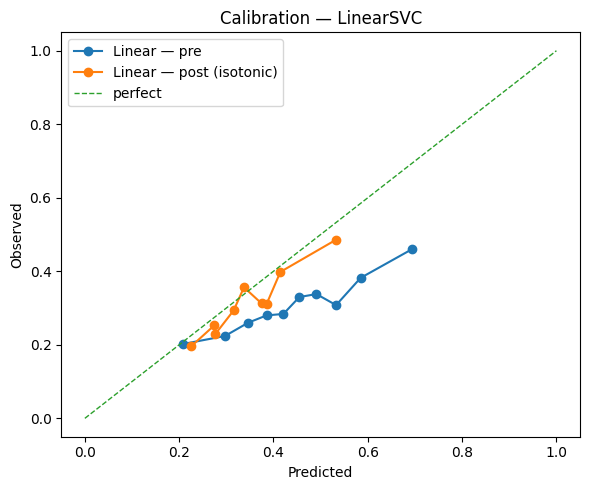

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


RBF — Brier pre (Platt): 0.2111
RBF — Brier post (isotonic): 0.2676


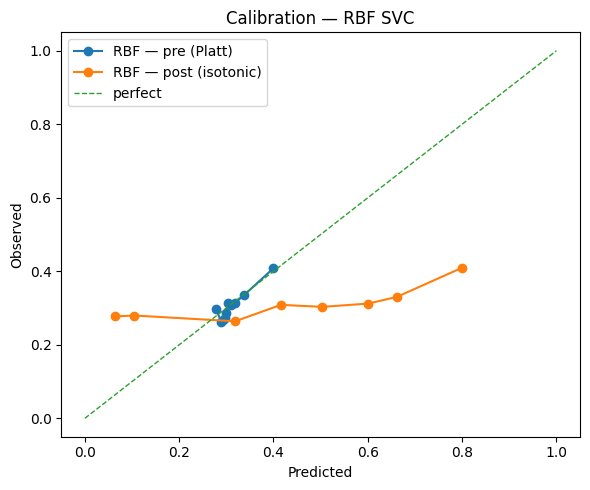

In [ ]:
# Calibration curves & Brier score
import numpy as np, matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# LinearSVC
# PRE: use an uncalibrated decision_function -> map to [0,1] by rank (for curve shape only)
lin_uncal = Pipeline([("pre", pre), ("svc", LinearSVC(C=1.0, random_state=42))]).fit(X_train, y_train)
dec_test = lin_uncal.decision_function(X_test)
# normalize to [0,1] (not a true prob; for visual comparison only)
p_lin_pre = (dec_test - dec_test.min()) / (dec_test.max() - dec_test.min() + 1e-12)

# POST: use your calibrated linear
p_lin_post = probs_lin
print("Linear, Brier pre (scaled df):", round(brier_score_loss(y_test, p_lin_pre), 4))
print("Linear, Brier post (isotonic):", round(brier_score_loss(y_test, p_lin_post), 4))

pt_pre, pp_pre   = calibration_curve(y_test, p_lin_pre,  n_bins=10, strategy="quantile")
pt_post, pp_post = calibration_curve(y_test, p_lin_post, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(pp_pre, pt_pre, marker="o", label="Linear, pre")
plt.plot(pp_post, pt_post, marker="o", label="Linear, post (isotonic)")
plt.plot([0,1],[0,1],'--',lw=1,label="perfect")
plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("Calibration, LinearSVC")
plt.legend(); plt.tight_layout(); plt.show()

# RBF SVC
# PRE: native probabilities from SVC(probability=True) use Platt scaling internally
p_rbf_pre = probs_rbf

# POST: external isotonic calibration on a validation slice
val = train.iloc[-5000:]
rbf_prefit = Pipeline([("pre", pre), ("svc", SVC(C=1.0, kernel="rbf", gamma="scale", probability=True, random_state=42))])
rbf_prefit.fit(X_train, y_train)
rbf_cal = CalibratedClassifierCV(rbf_prefit, cv="prefit", method="isotonic")
rbf_cal.fit(val[features], val[target])
p_rbf_post = rbf_cal.predict_proba(X_test)[:,1]

print("RBF, Brier pre (Platt):", round(brier_score_loss(y_test, p_rbf_pre), 4))
print("RBF, Brier post (isotonic):", round(brier_score_loss(y_test, p_rbf_post), 4))

pt_pre, pp_pre   = calibration_curve(y_test, p_rbf_pre,  n_bins=10, strategy="quantile")
pt_post, pp_post = calibration_curve(y_test, p_rbf_post, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(pp_pre, pt_pre, marker="o", label="RBF, pre (Platt)")
plt.plot(pp_post, pt_post, marker="o", label="RBF, post (isotonic)")
plt.plot([0,1],[0,1],'--',lw=1,label="perfect")
plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title("Calibration, RBF SVC")
plt.legend(); plt.tight_layout(); plt.show()

#### Support-vector counts (linear & RBF) and threshold sensitivity

Support vectors (linear SVC via libsvm): 13812 / 20000
Support vectors (RBF SVC):              14517 / 20000


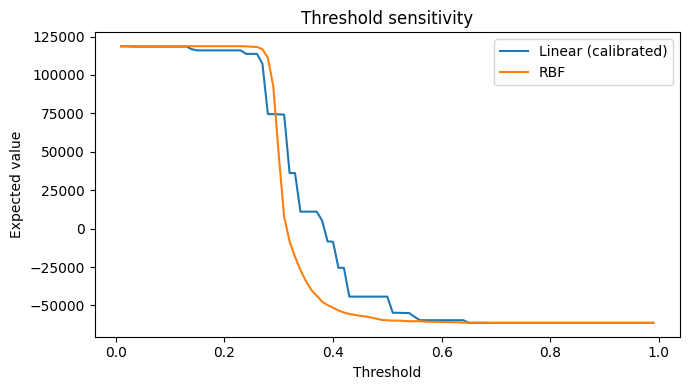

In [7]:
# Support-vector counts & threshold sensitivity
import numpy as np, matplotlib.pyplot as plt
from sklearn.svm import SVC

# True SV counts: need libsvm interface -> use SVC(kernel="linear") for count (on a manageable sample if huge)
# (LinearSVC doesn't expose support_; this is a standard workaround)
sub_n = min(len(X_train), 20000)
X_sub, y_sub = X_train.iloc[:sub_n], y_train.iloc[:sub_n]
svc_linear = Pipeline([("pre", pre), ("svc", SVC(kernel="linear", C=1.0, probability=False, random_state=42))]).fit(X_sub, y_sub)
n_sv_linear = int(svc_linear.named_steps["svc"].n_support_.sum())

svc_rbf = Pipeline([("pre", pre), ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42))]).fit(X_sub, y_sub)
n_sv_rbf = int(svc_rbf.named_steps["svc"].n_support_.sum())

print(f"Support vectors (linear SVC via libsvm): {n_sv_linear} / {len(X_sub)}")
print(f"Support vectors (RBF SVC):              {n_sv_rbf} / {len(X_sub)}")

# Threshold sensitivity (Expected Value curve) using calibrated linear and RBF probs
from sklearn.metrics import confusion_matrix

gain_tp, cost_fp, cost_fn, cost_tn = 100.0, 10.0, 40.0, 0.0
def ev_curve(y_true, p):
    ts = np.linspace(0.01, 0.99, 99); evs = []
    for t in ts:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        evs.append(tp*gain_tp - fp*cost_fp - fn*cost_fn - tn*cost_tn)
    return ts, np.array(evs)

ts_lin, ev_lin = ev_curve(y_test, probs_lin)
ts_rbf, ev_rbf = ev_curve(y_test, probs_rbf)

plt.figure(figsize=(7,4))
plt.plot(ts_lin, ev_lin, label="Linear (calibrated)")
plt.plot(ts_rbf, ev_rbf, label="RBF")
plt.xlabel("Threshold"); plt.ylabel("Expected value"); plt.title("Threshold sensitivity")
plt.legend(); plt.tight_layout(); plt.show()

#### Driver summary
   - Linear: Top standardized coefficients (weights from LinearSVC after scaling/OHE)
   - RBF: Permutation importances (+ PDPs) for top features
   - PDPs are computed on the pipeline with raw column names; scikit-learn will route these through your ColumnTransformer.

Top +coefficients (increase conversion odds):


,feature,coef
1,num__pages_per_session,0.064442
4,num__pricing_views_l7,0.063917
25,bin__discount_flag,0.054802
3,num__time_on_site_s,0.050898
6,num__past_purchases,0.047649
0,num__spend_l7,0.042521
12,cat__ad_channel_search,0.037879
2,num__sessions_l30,0.034571
7,num__tenure_days,0.017253
5,num__email_opens_l30,0.015128


Top -coefficients (decrease conversion odds):


,feature,coef
22,cat__campaign_nonbrand,-0.121550
19,cat__region_LATAM,-0.103763
15,cat__device_mobile,-0.087889
16,cat__device_tablet,-0.077329
24,cat__campaign_seasonal,-0.060421
10,cat__ad_channel_display,-0.053674
9,cat__ad_channel_direct,-0.050548
13,cat__ad_channel_social,-0.048114
11,cat__ad_channel_email,-0.040936
26,bin__competitor_visits,-0.040420


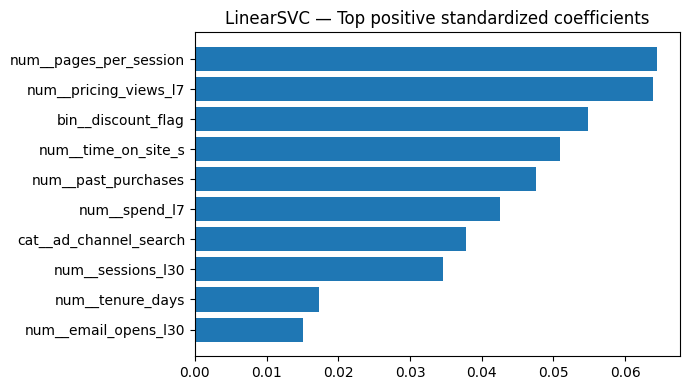

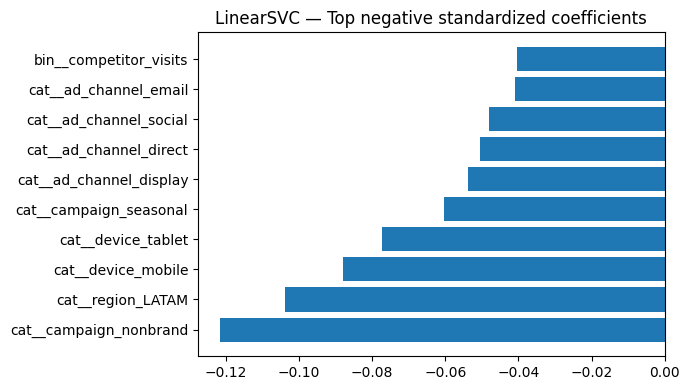

,orig,mean
8,pricing_views_l7,0.017967
7,past_purchases,0.009792
6,pages_per_session,0.005163
13,time_on_site_s,0.003700
1,campaign,0.002756
11,spend_l7,0.002042
4,discount_flag,0.001836
2,competitor_visits,0.001644
3,device,0.000632
10,sessions_l30,-0.000102


/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 8 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


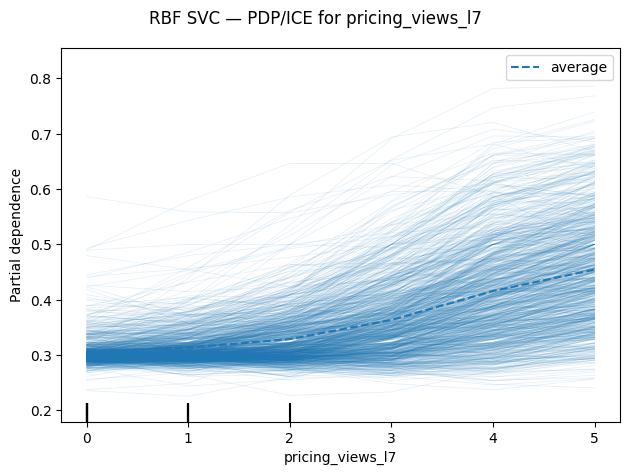

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


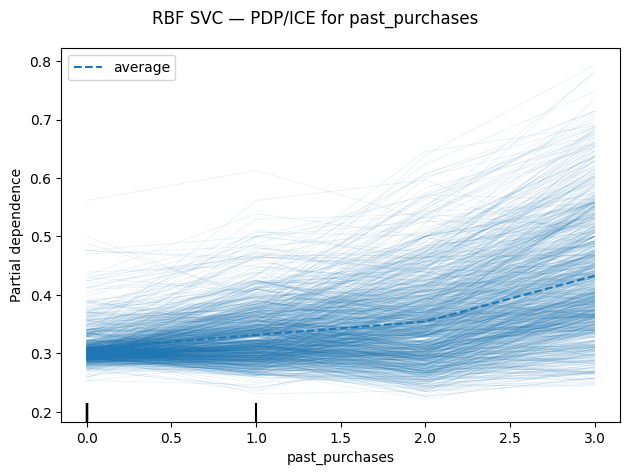

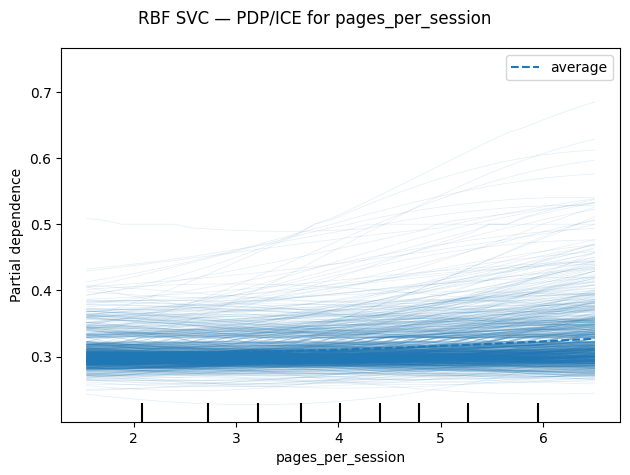

In [ ]:
# Driver summary (Linear vs RBF)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Linear: top standardized coefficients
lin_fit = lin  # already fitted pipeline
feat_names = lin_fit.named_steps["pre"].get_feature_names_out()
coef = lin_fit.named_steps["svc"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feat_names, "coef": coef}).sort_values("coef", ascending=False)
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10).sort_values("coef")

print("Top +coefficients (increase conversion odds):")
display(top_pos)
print("Top -coefficients (decrease conversion odds):")
display(top_neg)

plt.figure(figsize=(7,4))
plt.barh(top_pos["feature"][::-1], top_pos["coef"][::-1])
plt.title("LinearSVC, Top positive standardized coefficients")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("LinearSVC, Top negative standardized coefficients")
plt.tight_layout(); plt.show()

# RBF: permutation importances + PDPs for top features (original column names)
pi = permutation_importance(rbf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1, scoring="average_precision")
fn_pi = list(features)
pi_df = pd.DataFrame({"feature": fn_pi, "mean": pi.importances_mean, "std": pi.importances_std})
pi_df = pi_df.sort_values("mean", ascending=False)

# Map transformed feature names back to original columns for PDP
def to_original(feat):
    if "__" in feat:
        feat = feat.split("__",1)[1]
    for base in ["ad_channel","device","region","campaign"]:
        if feat.startswith(base + "_"):
            return base
    for base in ["spend_l7","pages_per_session","sessions_l30","time_on_site_s","pricing_views_l7","email_opens_l30","past_purchases","tenure_days","discount_flag","competitor_visits"]:
        if feat.startswith(base):
            return base
    return feat

orig_rank = (pi_df.assign(orig=pi_df["feature"].map(to_original))
                 .groupby("orig", as_index=False)["mean"].sum()
                 .sort_values("mean", ascending=False))

display(orig_rank.head(12))

# PDPs for top 3 original features
top3 = orig_rank["orig"].head(3).tolist()
for f in top3:
    try:
        PartialDependenceDisplay.from_estimator(rbf, X_test, [f], kind="both", grid_resolution=30, ice_lines_kw={"alpha":0.12})
        plt.suptitle(f"RBF SVC, PDP/ICE for {f}")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"PDP failed for {f}: {e}")

#### One-line plain-language driver summary

In [24]:
# Plain-language driver summary
# For Linear: use top coefficients; for RBF: use aggregated permutation importances
if "coef" in locals():
    top_lin = coef_df.assign(absv=coef_df["coef"].abs()).sort_values("absv", ascending=False).head(4)
    share = float(top_lin["absv"].sum() / coef_df["coef"].abs().sum() + 1e-12)
    drivers = ", ".join(top_lin["feature"].tolist())
    print(f"Policy summary (Linear): ~{share*100:.0f}% of the decision signal comes from {drivers}. Prioritize data quality and controls here.")
else:
    top_rbf = orig_rank.head(4)
    share = float(top_rbf["mean"].sum() / orig_rank["mean"].sum() + 1e-12)
    drivers = ", ".join(top_rbf["orig"].tolist())
    print(f"Policy summary (RBF): ~{share*100:.0f}% of the decision signal comes from {drivers}. Prioritize data quality and controls here.")

Policy summary (Linear): ~30% of the decision signal comes from cat__campaign_nonbrand, cat__region_LATAM, cat__device_mobile, cat__device_tablet. Prioritize data quality and controls here.


#### Decision table (template): probability → action by season/segment with owners & SLA

In [25]:
# Decision table mapping probabilities to actions by season/segment
import numpy as np, pandas as pd

# Build helper columns: season from timestamp; segment examples
test_ct = test.copy()
test_ct["season"] = test_ct["ts"].dt.month%12//3 + 1  # 1=Winter,2=Spring,3=Summer,4=Fall
test_ct["p_lin"] = probs_lin
test_ct["p_rbf"] = probs_rbf

# Choose one model's probabilities for actioning; here: calibrated linear
test_ct["p"] = test_ct["p_lin"]

# Define probability bands -> actions/owners/SLA
def band(p):
    if p >= 0.80: return "P3: High-touch offer"
    if p >= 0.50: return "P2: Standard offer"
    if p >= 0.30: return "P1: Nurture"
    return "P0: No action"

owner_map = {
    "P3: High-touch offer": "Sales (AE)",
    "P2: Standard offer": "Lifecycle Marketing",
    "P1: Nurture": "CRM / Email",
    "P0: No action": "No owner"
}
sla_map = {
    "P3: High-touch offer": "Respond < 24h",
    "P2: Standard offer": "Campaign within 72h",
    "P1: Nurture": "Weekly cadence",
    "P0: No action": "—"
}

test_ct["policy"] = test_ct["p"].apply(band)
test_ct["owner"]  = test_ct["policy"].map(owner_map)
test_ct["SLA"]    = test_ct["policy"].map(sla_map)

# Summarize by season & a key segment (e.g., ad_channel); adjust to your needs
summary = (test_ct.groupby(["season","ad_channel","policy"], as_index=False)
                  .agg(n=("converted","size"),
                       avg_p=("p","mean"),
                       conv_rate=(target,"mean")))

# Sort and display compact "decision table"
summary = summary.sort_values(["season","ad_channel","policy","avg_p"], ascending=[True, True, False, False])

# Attach owners/SLA for each policy row
summary["owner"] = summary["policy"].map(owner_map)
summary["SLA"]   = summary["policy"].map(sla_map)
display(summary.head(40))

# Optional: export to CSV for ops handoff
# summary.to_csv("svm_decision_table_by_season_segment.csv", index=False)

,season,ad_channel,policy,n,avg_p,conv_rate,owner,SLA
2,2,affiliate,P2: Standard offer,3,0.506667,0.666667,Lifecycle Marketing,Campaign within 72h
1,2,affiliate,P1: Nurture,83,0.348676,0.301205,CRM / Email,Weekly cadence
0,2,affiliate,P0: No action,44,0.265771,0.363636,No owner,—
5,2,direct,P2: Standard offer,6,0.529365,0.833333,Lifecycle Marketing,Campaign within 72h
4,2,direct,P1: Nurture,38,0.355772,0.394737,CRM / Email,Weekly cadence
3,2,direct,P0: No action,34,0.264666,0.147059,No owner,—
8,2,display,P2: Standard offer,6,0.513620,0.666667,Lifecycle Marketing,Campaign within 72h
7,2,display,P1: Nurture,75,0.354159,0.333333,CRM / Email,Weekly cadence
6,2,display,P0: No action,52,0.260605,0.250000,No owner,—
11,2,email,P2: Standard offer,5,0.534566,0.200000,Lifecycle Marketing,Campaign within 72h
